<a href="https://colab.research.google.com/github/abdalrahmenyousifMohamed/Master-TensorFlow/blob/main/4_3_Recurrent_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 4: Dipping Toes in Deep Learning

## Recurrent Neural Networks

Recurrent neural networks (RNNs) have proven their success in learning from time-series data.

In this chapter, we will use a RNN to learn to predict CO2 concentration levels in the next 5 years. Specifically, you will learn the following.

* How to do simple data exploration on time series data
* How to define a RNN model
* How to transfrom time series data to train a sequential model
* How to train a model

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch04-Deep-Networks-with-Keras/4.3.Recurrent_networks.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>

In [1]:
import random
import os
import pandas as pd
from tensorflow.keras import layers, models
import tensorflow as tf
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

def fix_random_seed(seed):
    """ Setting the random seed of various libraries """
    try:
        np.random.seed(seed)
    except NameError:
        print("Warning: Numpy is not imported. Setting the seed for Numpy failed.")
    try:
        tf.random.set_seed(seed)
    except NameError:
        print("Warning: TensorFlow is not imported. Setting the seed for TensorFlow failed.")
    try:
        random.seed(seed)
    except NameError:
        print("Warning: random module is not imported. Setting the seed for random failed.")

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = "true"
# Fixing the random seed
fix_random_seed(4321)
print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.12.0


## Reading the data

In [2]:
# Section 4.3

import pandas as pd
import requests
import os

def download_data():
    """ This function downloads the CO2 data from
    https://datahub.io/core/co2-ppm/r/co2-mm-gl.csv
    if the file doesn't already exist
    """
    save_dir = "data"
    save_path = os.path.join(save_dir, 'co2-mm-gl.csv')

    # Create directories if they are not there
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Download the data and save
    if not os.path.exists(save_path):
        url = "https://datahub.io/core/co2-ppm/r/co2-mm-gl.csv"
        r = requests.get(url)
        with open(save_path, 'wb') as f:
            f.write(r.content)
    else:
        print("co2-mm-gl.csv already exists. Not downloading.")
    return save_path

# Downloading the data
save_path = download_data()

# Load the data
data = pd.read_csv(save_path)
data.head()

,Date,Decimal Date,Average,Trend
0,1980-01-01,1980.042,338.45,337.83
1,1980-02-01,1980.125,339.15,338.10
2,1980-03-01,1980.208,339.48,338.13
3,1980-04-01,1980.292,339.87,338.25
4,1980-05-01,1980.375,340.30,338.78


In [3]:
# Section 4.3

# Set the date as the index of the dataframe
data = data.set_index('Date')

## Plotting CO2 concentration over time

<Axes: xlabel='Date'>

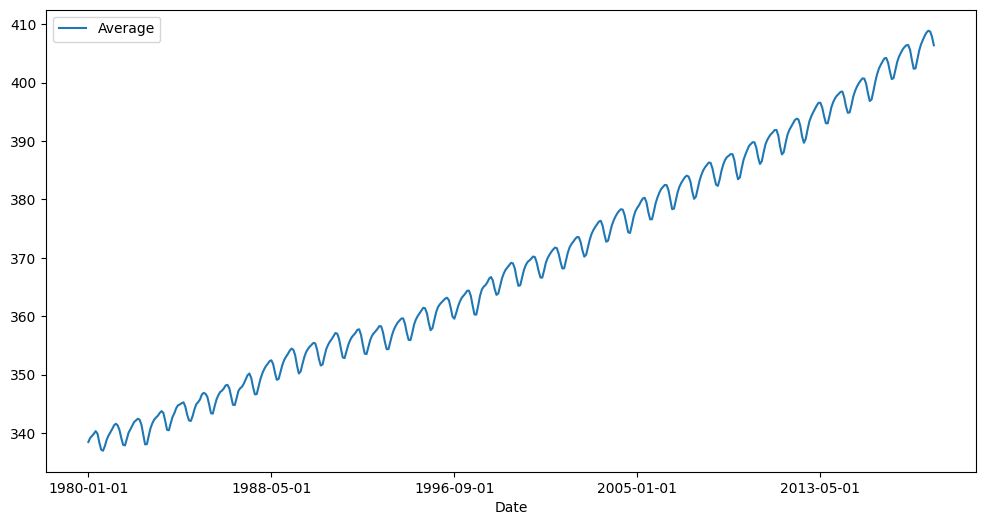

In [4]:
# Section 4.3

# Plotting the CO2 trend
data[["Average"]].plot(figsize=(12,6))

## Creating the `Average Diff` column

`Average Diff` is computed as,

`Average Diff(t) = Average(t) - Average(t-1)`

In [5]:
# Section 4.3

data["Average Diff"] = data["Average"] - data["Average"].shift(1).fillna(method='bfill')
data.head()

,Decimal Date,Average,Trend,Average Diff
Date,,,,
1980-01-01,1980.042,338.45,337.83,0.00
1980-02-01,1980.125,339.15,338.10,0.70
1980-03-01,1980.208,339.48,338.13,0.33
1980-04-01,1980.292,339.87,338.25,0.39
1980-05-01,1980.375,340.30,338.78,0.43


In [24]:
data

,Decimal Date,Average,Trend,Average Diff
Date,,,,
1980-01-01,1980.042,338.45,337.83,0.00
1980-02-01,1980.125,339.15,338.10,0.70
1980-03-01,1980.208,339.48,338.13,0.33
1980-04-01,1980.292,339.87,338.25,0.39
1980-05-01,1980.375,340.30,338.78,0.43
...,...,...,...,...
2018-03-01,2018.208,408.57,406.92,0.58
2018-04-01,2018.292,408.88,407.06,0.31
2018-05-01,2018.375,408.75,407.14,-0.13


<Axes: xlabel='Date'>

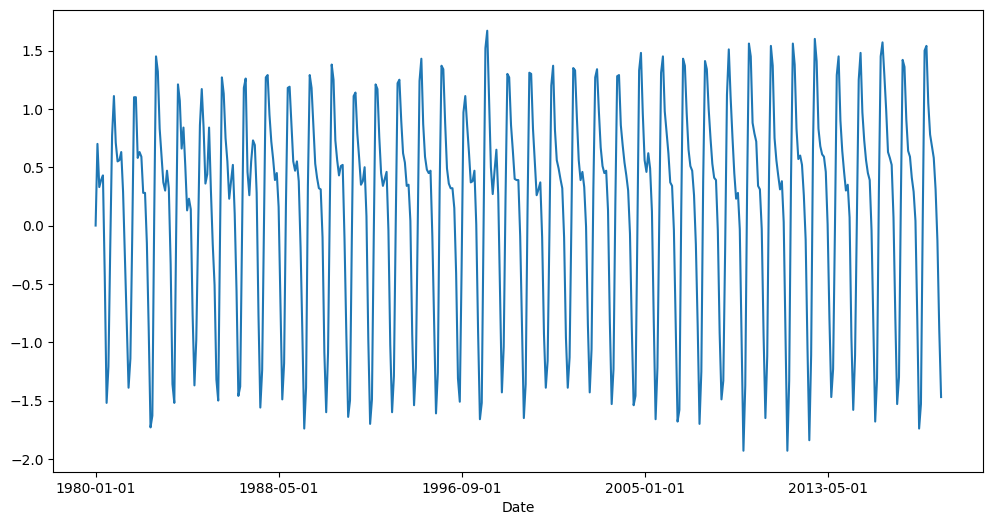

In [6]:
# Section 4.3

data["Average Diff"].plot(figsize=(12,6))

## Generating time-series data for the model

In [7]:
data["Average Diff"].values.shape

(463,)

In [9]:
# Section 4.3
# Code listing 4.4/Code listing 4.5

import numpy as np

def generate_data(co2_arr,n_seq):
    """ Generating data for the model.
    Input is a matrix of size (n x n_seq) and
    Output is a vector of size n. """

    x, y = [],[]
    for i in range(co2_arr.shape[0]-n_seq):
        x.append(co2_arr[i:i+n_seq-1])
        y.append(co2_arr[i+n_seq-1:i+n_seq])
    x = np.array(x).reshape(-1,n_seq-1,1)
    y = np.array(y)
    return x,y

# Generating the data
x, y = generate_data(data["Average Diff"].values, 13)

# Let's print some data and see what we got
print("Original values: ", data["Average Diff"].values[:20])
print()
i = 0
for xx, yy in zip(x,y):
    print('x: ',xx.ravel(), ' y: ', yy.ravel())
    i += 1
    if i>5: break

Original values:  [ 0.    0.7   0.33  0.39  0.43 -0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71
  0.55  0.56  0.63  0.29 -0.27 -0.81 -1.39 -1.14]

x:  [ 0.    0.7   0.33  0.39  0.43 -0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71]  y:  [0.55]
x:  [ 0.7   0.33  0.39  0.43 -0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71  0.55]  y:  [0.56]
x:  [ 0.33  0.39  0.43 -0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71  0.55  0.56]  y:  [0.63]
x:  [ 0.39  0.43 -0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71  0.55  0.56  0.63]  y:  [0.29]
x:  [ 0.43 -0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71  0.55  0.56  0.63  0.29]  y:  [-0.27]
x:  [-0.44 -1.52 -1.21 -0.18  0.77  1.11  0.71  0.55  0.56  0.63  0.29 -0.27]  y:  [-0.81]


In [14]:
y.shape

(450, 1)

## Defining and training the model

In [10]:
# Section 4.3

from tensorflow.keras import layers, models
import tensorflow.keras.backend as K

K.clear_session()

# Defining the model
rnn = models.Sequential([
    layers.SimpleRNN(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
# Compiling the model
rnn.compile(loss='mse', optimizer='adam')

In [11]:
# Section 4.3
rnn.fit(x, y, shuffle=True, batch_size=64, epochs=25)

Epoch 1/25
8/8 [==============================] - 2s 6ms/step - loss: 0.4433
Epoch 2/25
8/8 [==============================] - 0s 4ms/step - loss: 0.0488
Epoch 3/25
8/8 [==============================] - 0s 4ms/step - loss: 0.0433
Epoch 4/25
8/8 [==============================] - 0s 5ms/step - loss: 0.0279
Epoch 5/25
8/8 [==============================] - 0s 5ms/step - loss: 0.0329
Epoch 6/25
8/8 [==============================] - 0s 5ms/step - loss: 0.0278
Epoch 7/25
8/8 [==============================] - 0s 5ms/step - loss: 0.0277
Epoch 8/25
8/8 [==============================] - 0s 5ms/step - loss: 0.0241
Epoch 9/25
8/8 [==============================] - 0s 6ms/step - loss: 0.0223
Epoch 10/25
8/8 [==============================] - 0s 5ms/step - loss: 0.0198
Epoch 11/25
8/8 [==============================] - 0s 4ms/step - loss: 0.0191
Epoch 12/25
8/8 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 13/25
8/8 [==============================] - 0s 5ms/step - loss: 0.

## Predicting using the trained model

In [15]:
# Section 4.3
# Code listing 4.6

import numpy as np

# Getting the last 12 values from the history to generate the first prediction
history = data["Average Diff"].values[-12:].reshape(1,-1,1)

# To hold the absolute values
true_vals = []

# Holds the very last value in the history
prev_true = data["Average"].values[-1]

# Making predictions for 60 time steps
for i in range(60):
    # Make a single prediction
    p_diff = rnn.predict(history).reshape(1,-1,1)

    # Modifying the history so that we have
    history = np.concatenate((history[:,1:,:],p_diff),axis=1)
    # Generating the absolute prediction
    true_vals.append(prev_true+p_diff[0,0,0])
    # Updating the prev_true
    prev_true = true_vals[-1]

print("Predictions: {}".format(true_vals[:10]))

1/1 [==============================] - 0s 31ms/step
Predictions: [405.08082939624785, 405.0378320136666, 406.12557160049676, 407.2120187202096, 407.9058722177148, 408.49686901956795, 408.8947023668885, 409.1679194191098, 409.44131173878907, 409.4840089672804]


## Plotting the current values and predictions

In [19]:
data["Average"].values[-1]+true_vals

array([811.4708294 , 811.42783201, 812.5155716 , 813.60201872,
       814.29587222, 814.88686902, 815.28470237, 815.55791942,
       815.83131174, 815.87400897, 815.17201246, 813.7074299 ,
       812.32074024, 812.17960341, 813.23527141, 814.32430871,
       815.00066985, 815.55327053, 815.92595582, 816.20377187,
       816.48133995, 816.5723795 , 815.94429502, 814.52669403,
       813.0986366 , 812.86658294, 813.88467975, 814.98294277,
       815.66364331, 816.22255655, 816.59466003, 816.87712605,
       817.16122348, 817.28603975, 816.7049071 , 815.32768993,
       813.86776058, 813.54595236, 814.51063715, 815.62005935,
       816.31054924, 816.87402789, 817.2528979 , 817.54066317,
       817.82381235, 817.97442447, 817.43019996, 816.08715497,
       814.59713827, 814.18259086, 815.08425607, 816.20323039,
       816.90582235, 817.4707423 , 817.86291508, 818.1590219 ,
       818.43639685, 818.60292351, 818.09158802, 816.78210091])

In [17]:
data["Average"].values[-1]

406.39

### The purpose of including the last true value in the list of predictions is to maintain continuity and provide context. This is often done when generating predictions for a time series. It helps in several ways:

- Initial Value: It ensures that the first predicted value has a reference point (the last true value) from which the model's predictions start. This is especially important when presenting or visualizing the predicted time series.

- Comparison: Having the last true value in the list allows for easy comparison between the model's predictions and the ground truth. You can assess how well the model's predictions align with the actual observations.

- Visual Representation: When plotting or visualizing the time series, including the last true value provides a smooth transition from the historical data to the predicted values.

In [20]:
[data.index[-1]]

['2018-07-01']

In [23]:
[pd.to_datetime(data.index[-1], format="%Y-%m-%d")+pd.DateOffset(months=i+1) for i in range(60)]

[Timestamp('2018-08-01 00:00:00'),
 Timestamp('2018-09-01 00:00:00'),
 Timestamp('2018-10-01 00:00:00'),
 Timestamp('2018-11-01 00:00:00'),
 Timestamp('2018-12-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-02-01 00:00:00'),
 Timestamp('2019-03-01 00:00:00'),
 Timestamp('2019-04-01 00:00:00'),
 Timestamp('2019-05-01 00:00:00'),
 Timestamp('2019-06-01 00:00:00'),
 Timestamp('2019-07-01 00:00:00'),
 Timestamp('2019-08-01 00:00:00'),
 Timestamp('2019-09-01 00:00:00'),
 Timestamp('2019-10-01 00:00:00'),
 Timestamp('2019-11-01 00:00:00'),
 Timestamp('2019-12-01 00:00:00'),
 Timestamp('2020-01-01 00:00:00'),
 Timestamp('2020-02-01 00:00:00'),
 Timestamp('2020-03-01 00:00:00'),
 Timestamp('2020-04-01 00:00:00'),
 Timestamp('2020-05-01 00:00:00'),
 Timestamp('2020-06-01 00:00:00'),
 Timestamp('2020-07-01 00:00:00'),
 Timestamp('2020-08-01 00:00:00'),
 Timestamp('2020-09-01 00:00:00'),
 Timestamp('2020-10-01 00:00:00'),
 Timestamp('2020-11-01 00:00:00'),
 Timestamp('2020-12-

In [22]:
[pd.DateOffset(months=i+1) for i in range(60)]

[<DateOffset: months=1>,
 <DateOffset: months=2>,
 <DateOffset: months=3>,
 <DateOffset: months=4>,
 <DateOffset: months=5>,
 <DateOffset: months=6>,
 <DateOffset: months=7>,
 <DateOffset: months=8>,
 <DateOffset: months=9>,
 <DateOffset: months=10>,
 <DateOffset: months=11>,
 <DateOffset: months=12>,
 <DateOffset: months=13>,
 <DateOffset: months=14>,
 <DateOffset: months=15>,
 <DateOffset: months=16>,
 <DateOffset: months=17>,
 <DateOffset: months=18>,
 <DateOffset: months=19>,
 <DateOffset: months=20>,
 <DateOffset: months=21>,
 <DateOffset: months=22>,
 <DateOffset: months=23>,
 <DateOffset: months=24>,
 <DateOffset: months=25>,
 <DateOffset: months=26>,
 <DateOffset: months=27>,
 <DateOffset: months=28>,
 <DateOffset: months=29>,
 <DateOffset: months=30>,
 <DateOffset: months=31>,
 <DateOffset: months=32>,
 <DateOffset: months=33>,
 <DateOffset: months=34>,
 <DateOffset: months=35>,
 <DateOffset: months=36>,
 <DateOffset: months=37>,
 <DateOffset: months=38>,
 <DateOffset: months=

In [25]:
data["Average"].shape[0]+60

523

Text(0.5, 1.0, 'Evolution of CO2 Concentration over Time')

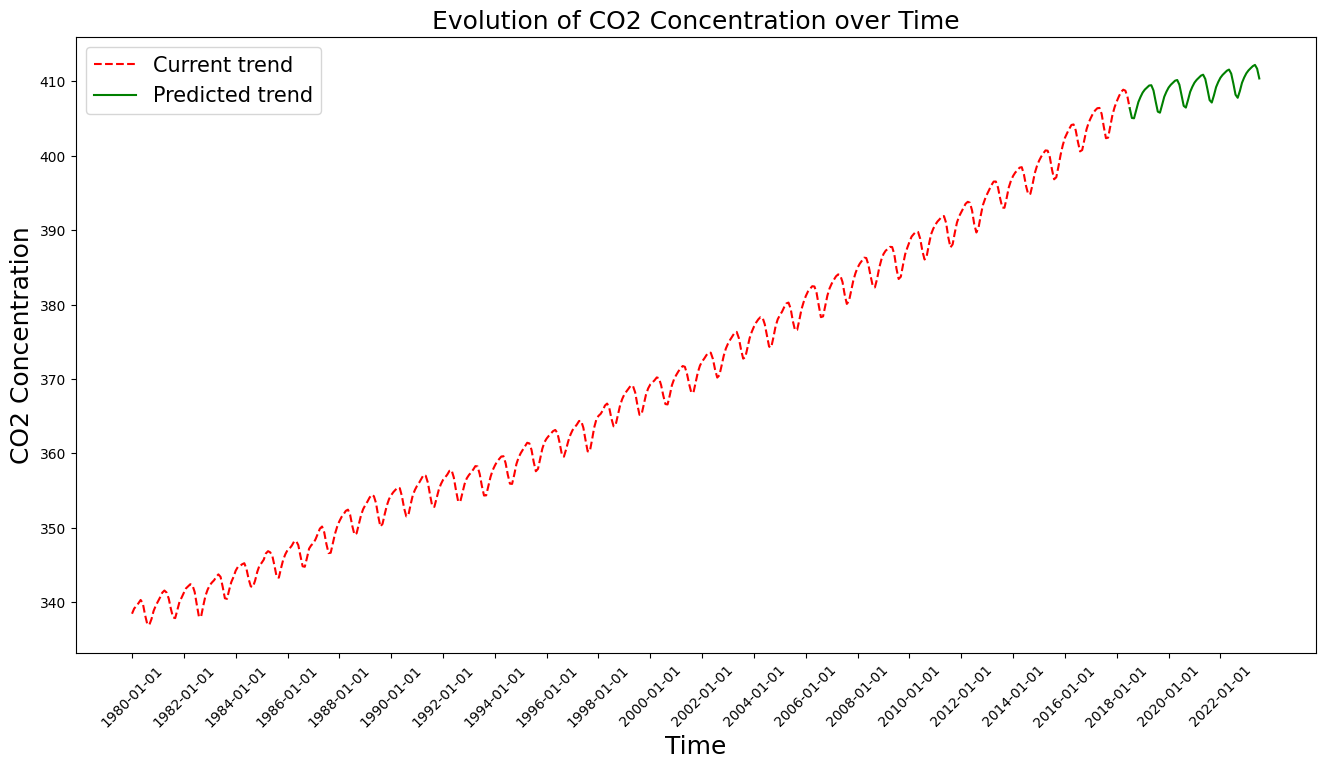

In [26]:
# Section 4.3

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Plotting the current and predicted trends
plt.figure(figsize=(16,8))

# Plotting the current trend
plt.plot(data["Average"], c='r', linestyle='--', label="Current trend")

# Creating a pd.Series from predictions
pred_ser = pd.Series(
    [data["Average"].values[-1]]+true_vals,
    index=[data.index[-1]]+[pd.to_datetime(data.index[-1], format="%Y-%m-%d")+pd.DateOffset(months=i+1) for i in range(60)]
)
pred_ser.index = pd.to_datetime(pred_ser.index).strftime('%Y-%m-%d')

# Plotting the predictions
plt.plot(pred_ser, c='g', label='Predicted trend')

# Annotating the plot
plt.xticks(np.arange(0, data["Average"].shape[0]+60, 24),rotation=45)
plt.xlabel('Time', fontsize=18)
plt.ylabel('CO2 Concentration', fontsize=18)
plt.legend(prop={'size': 15})
plt.title('Evolution of CO2 Concentration over Time', fontsize=18)